## Q3.1: Revised Team 22 Project

### Comments received
1.You may consider using geographical features to differentiate the carparks from each other.
Also, instead of using one ML model per carpark, we would recommend to use one model for all carparks.

2.The “web/phone application or integration with established wayfinding applications” is interesting and a good purpose, but it does not suit the theme of this module as much as doing data analysis. Do allocate your time and resources wisely if your team decide to do this.

### Revision of project
Having internalised the comments, we have decided to use a model for all carparks. By comparing 3 models (MLP,LR and LSTM), we will use the final selected model to predict a user-specified carpark availability for the next 24 hours.


### Preamble
With the steadily increasing motor vehicle population in Singapore of 957,006 in 2018 to 988,755 in 2021, parking demand also experiences an upward trend. Parking has become a major traffic issue for not only vehicle owners but also to local authorities in charge of allocating scarce land resources.

### Proposed Solution
In summary, our group wishes to create a carpark recommendation system with the ability to forecast demand. Determining the carpark’s demand at certain timeframes will be done using time-series forecast which utilised historical data to predict future demand trends. This system generally benefits vehicle owners but can be extended to be gain insights into state planning (land allocation for vehicle parking or congestion). 

From a user’s perspective, users could provide the destination (in GPS 
coordinates) and the system will provide the top-n nearest carparks and their respective current available lots. If users were to specify a timeframe in the future, they will be able to view a demand forecast graph (as seen in figure below) in hourly intervals. This feature allows users to plan their trips accordingly to avoid peak demand periods. 

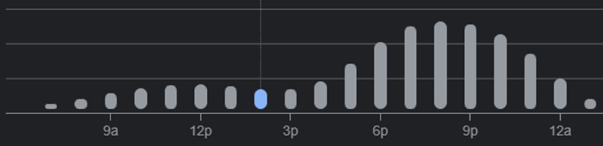


In [5]:
import pandas as pd
import numpy as np

# Data cleaning and preparation

We start by loading data from July to September 2022.

In [6]:
def load_data(month, days=31):
    full_df = pd.read_csv(f"./data/2022-{str(month)}-1.csv")
    for date in range(2, days+1):
        test_df = pd.read_csv(f'./data/2022-{str(month)}-{date}.csv')
        full_df = pd.concat([full_df, test_df])
    full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])
    full_df = full_df.set_index('timestamp')
    return full_df

In [7]:
jul = load_data(7)
aug = load_data(8)
sep = load_data(9, days=30)
full_data = pd.concat([jul, aug, sep])
full_data.dropna(inplace=True)

In [8]:
full_data['available rate'] = full_data['lots_available'] / full_data['total_lots']
full_data.dropna(inplace=True)
grped_full = full_data.groupby(full_data.carpark_number)

In [16]:
display(full_data)

,carpark_number,total_lots,lots_available,lot_type,available rate
timestamp,,,,,
2022-07-01 00:15:00,HE12,105,56,C,0.533333
2022-07-01 00:15:00,HLM,583,480,C,0.823328
2022-07-01 00:15:00,RHM,329,134,C,0.407295
2022-07-01 00:15:00,BM29,97,78,C,0.804124
2022-07-01 00:15:00,Q81,96,74,C,0.770833
...,...,...,...,...,...
2022-09-30 23:00:00,B65M,679,354,C,0.521355
2022-09-30 23:00:00,B65L,5,0,C,0.000000
2022-09-30 23:00:00,BE3,306,69,C,0.225490


For each carpark, we use the first 70% as training data and last 30% as testing data. We will use previous 8*24 hours availability as features to predict the next 24 hours availability.
We slice out the data for each carpark and resample them to fill in missing values. Then we prepare training and testing features and labels.

In [9]:
# helper method to create inputs and outputs from a given dataset
def prep_train_test(dataset, feature_len):
    X = []
    Y = []
    for i in range(feature_len, len(dataset)-24):
        X.append(dataset['available rate'][i-feature_len:i].values)
        Y.append(dataset['available rate'][i:i+24].values)
        # if np.isnan(X[-1]).any():
        #     print(X[-1])
        # if np.isnan(Y[-1]).any():
        #     print(Y[-1])
    return X, Y

In [11]:
carparks = grped_full.carpark_number.unique()
print(carparks)
trainX, trainY = [], []
testX, testY = [], []
feature_len = 24*8
split = 0.3
print("total ids:", len(carparks))
index = 0
for id in carparks:
    slice = grped_full.get_group(id[0])
    slice = slice.resample('1h').mean()
    if slice.shape[0] != 2208:
        print(slice.shape[0])
        print("Lossy data. Dropped")
        continue
    if slice.isnull().values.any():
        slice.fillna(method='ffill', inplace=True)
    split_index = int(slice.shape[0] * split)
    X_train1, Y_train1 = prep_train_test(slice[:split_index], feature_len)
    X_test1, Y_test1 = prep_train_test(slice[split_index:], feature_len)
    trainX.extend(X_train1)
    trainY.extend(Y_train1)
    testX.extend(X_test1)
    testY.extend(Y_test1)
    index += 1
    if index % 100 == 0:
        print(index, "done")
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
testY = np.array(testY)


carpark_number
A10      [A10]
A100    [A100]
A11      [A11]
A12      [A12]
A13      [A13]
         ...  
Y78M    [Y78M]
Y8        [Y8]
Y82M    [Y82M]
Y9        [Y9]
YHS      [YHS]
Name: carpark_number, Length: 1965, dtype: object
total ids: 1965
855
Lossy data. Dropped
100 done
200 done
300 done
400 done
500 done
730
Lossy data. Dropped
730
Lossy data. Dropped
600 done
700 done
800 done
900 done
1000 done
1100 done
83
Lossy data. Dropped
1200 done
1300 done
1400 done
1500 done
1600 done
1700 done
1800 done
1900 done


In [12]:
display(testY)

array([[0.6640625 , 0.625     , 0.625     , ..., 0.40234375, 0.4140625 ,
        0.42578125],
       [0.625     , 0.625     , 0.6171875 , ..., 0.4140625 , 0.42578125,
        0.48046875],
       [0.625     , 0.6171875 , 0.5078125 , ..., 0.42578125, 0.48046875,
        0.4609375 ],
       ...,
       [0.328125  , 0.328125  , 0.328125  , ..., 0.328125  , 0.55497159,
        0.328125  ],
       [0.328125  , 0.328125  , 0.328125  , ..., 0.55497159, 0.328125  ,
        0.328125  ],
       [0.328125  , 0.328125  , 0.328125  , ..., 0.328125  , 0.328125  ,
        0.328125  ]])

In [14]:
print("train test length:", trainX.shape, trainY.shape)
print("testing test length:", testX.shape, testY.shape)
print("input shape:", trainX[0].shape)
print("output shape:", trainY[0].shape)

train test length: (874606, 192) (874606, 24)
testing test length: (2608130, 192) (2608130, 24)
input shape: (192,)
output shape: (24,)


# Model 1: Multi-layer perceptron (MLP)

### In this section, we will use MLP model to predict the parking availability within the next 24 hours

In [8]:
# Import libraries
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
plt.style.use('ggplot')


In [9]:
## Q3 data
print(trainX.dtype,trainY.dtype)
print(testX.dtype,testY.dtype)
print(np.isnan(trainX).any() ,np.isnan(trainY).any())
print(np.isnan(testX).any() ,np.isnan(testY).any())
print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)

float64 float64
float64 float64
False False
False False
(874606, 192) (874606, 24)
(2608130, 192) (2608130, 24)


#### MLP regressor

In [11]:
#Hyperparameter tuning
#param = {"hidden_layer_sizes": [(1,),(50,)], "activation": ["identity", "logistic", "tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005]}
#model = MLPRegressor()
#gridsMLP = GridSearchCV(model,param)

#gridsMLP.fit(trainX, trainY)

#print(gridsMLP.best_params_)
#print(gridsMLP.best_estimator_)


In [11]:
model = MLPRegressor(activation='identity', hidden_layer_sizes=(200),
             max_iter=50, solver='adam', verbose=True, early_stopping=True)
model.fit(trainX, trainY)
print(model)

Iteration 1, loss = 0.00446114
Validation score: 0.947650
Iteration 2, loss = 0.00289243
Validation score: 0.950768
Iteration 3, loss = 0.00269672
Validation score: 0.949761
Iteration 4, loss = 0.00267952
Validation score: 0.951039
Iteration 5, loss = 0.00262903
Validation score: 0.949763
Iteration 6, loss = 0.00265979
Validation score: 0.952429
Iteration 7, loss = 0.00259801
Validation score: 0.952249
Iteration 8, loss = 0.00260760
Validation score: 0.951486
Iteration 9, loss = 0.00260361
Validation score: 0.952391
Iteration 10, loss = 0.00259726
Validation score: 0.951968
Iteration 11, loss = 0.00258945
Validation score: 0.951972
Iteration 12, loss = 0.00262849
Validation score: 0.952534
Iteration 13, loss = 0.00256387
Validation score: 0.949702
Iteration 14, loss = 0.00257773
Validation score: 0.952351
Iteration 15, loss = 0.00259034
Validation score: 0.952208
Iteration 16, loss = 0.00256943
Validation score: 0.952382
Iteration 17, loss = 0.00259175
Validation score: 0.952724
Iterat

In [23]:
# Saving the model
import pickle
filename = 'models/mlp_sklearn_model.sav'
pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))

In [19]:
Y_pred = model.predict(testX)

In [20]:
mlp_r2 = metrics.r2_score(testY, Y_pred)
mlp_mse = metrics.mean_squared_error(testY, Y_pred)
mlp_abs_error = mean_absolute_error(testY, Y_pred)
print(f"Model's r2score: {mlp_r2},\nMSE: {mlp_mse},\nMean Absolute Error: {mlp_abs_error*100} %")

Model's r2score: 0.9476901750206305,
MSE: 0.005626031969095141,
Mean Absolute Error: 4.137320245229594 %


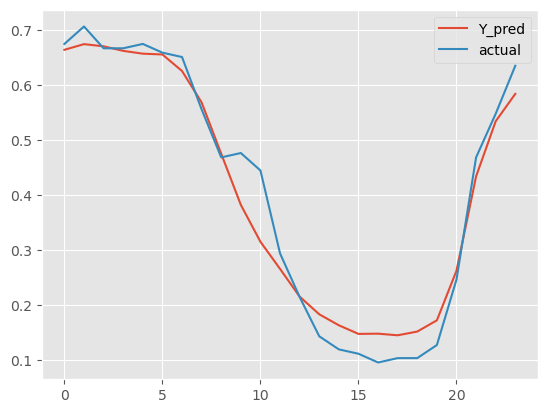

In [21]:
import random
idx = random.randint(0, len(testX))
plt.plot(Y_pred[idx], label='Y_pred')
plt.plot(testY[idx], label='actual')
plt.legend()

Text(0, 0.5, 'Actual')

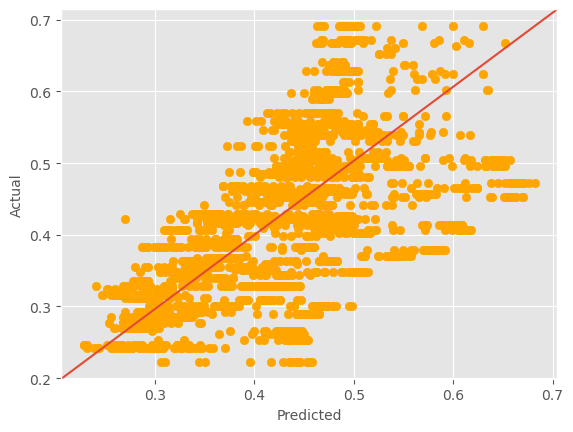

In [22]:
for idx in range(0, 100):
    plt.scatter(Y_pred[idx], testY[idx], label='Y_pred', color='orange')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)

# Model 2: Linear Regression

In [44]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(trainX, trainY)

LinearRegression()

In [45]:
# Saving the model
import pickle
filename = 'models/lr_sklearn_model.sav'
pickle.dump(model_lr, open(filename, 'wb'))
model_lr = pickle.load(open(filename, 'rb'))

In [46]:
y_pred_lr = model_lr.predict(testX)
display(trainX)

array([[0.40104167, 0.33984375, 0.328125  , ..., 0.5859375 , 0.5625    ,
        0.51953125],
       [0.33984375, 0.328125  , 0.328125  , ..., 0.5625    , 0.51953125,
        0.46875   ],
       [0.328125  , 0.328125  , 0.32421875, ..., 0.51953125, 0.46875   ,
        0.453125  ],
       ...,
       [0.43772727, 0.43772727, 0.40625   , ..., 0.40625   , 0.40625   ,
        0.40625   ],
       [0.43772727, 0.40625   , 0.40625   , ..., 0.40625   , 0.40625   ,
        0.40625   ],
       [0.40625   , 0.40625   , 0.40625   , ..., 0.40625   , 0.40625   ,
        0.40625   ]])

[84176, 2414674, 773683, 830611, 1236733, 295200, 1505122, 536178, 2335096, 1987511]


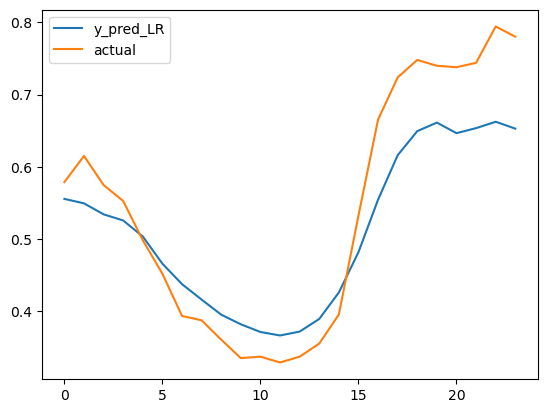

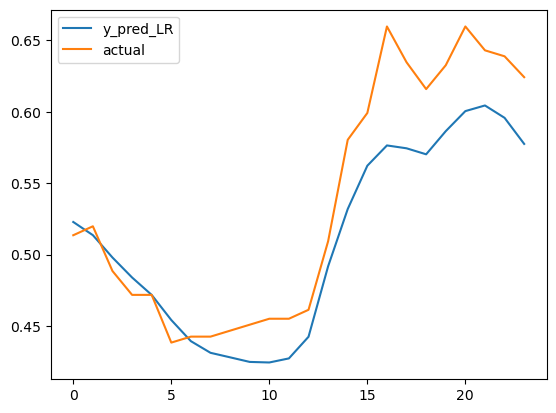

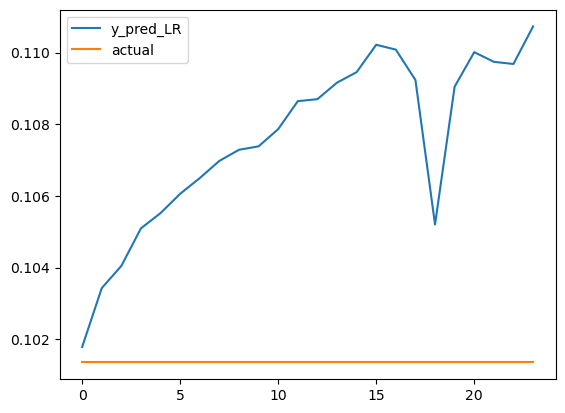

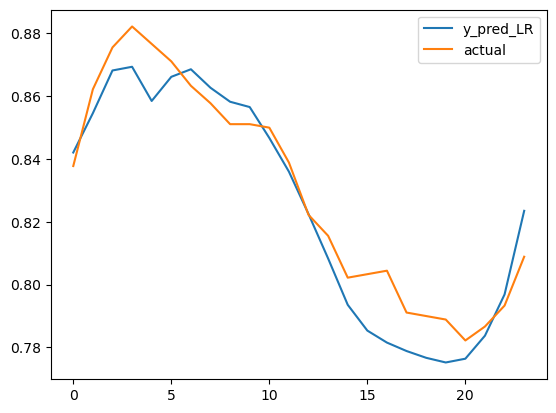

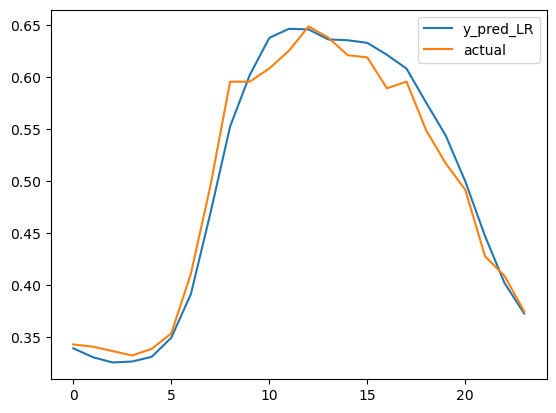

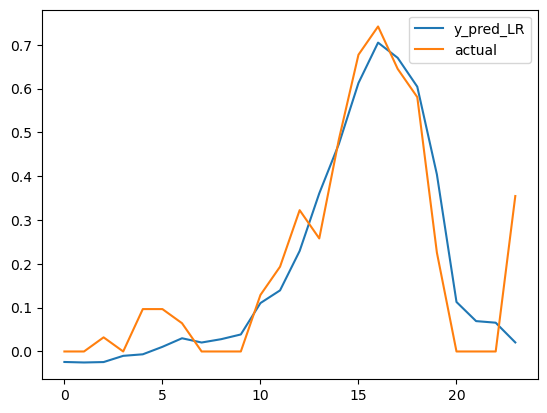

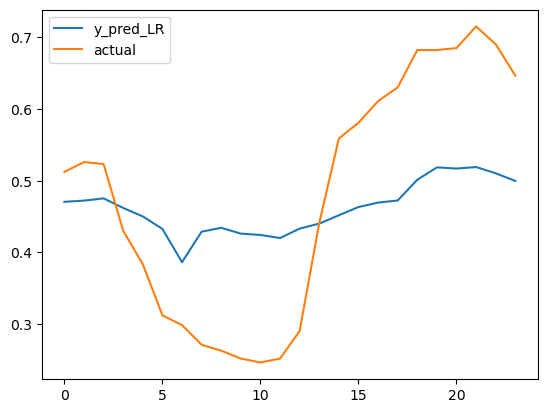

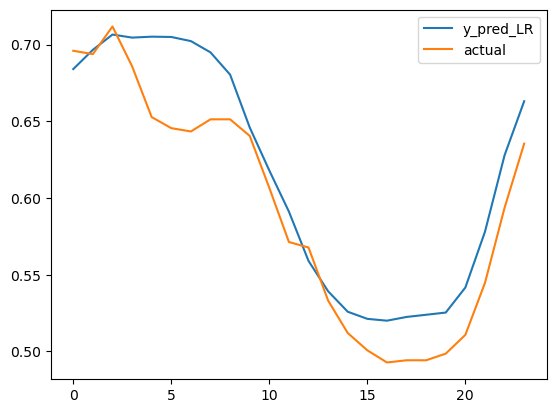

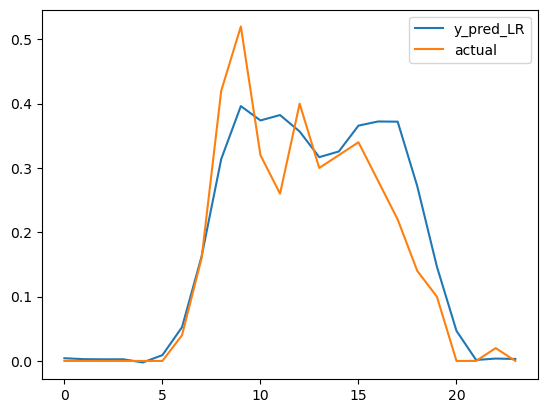

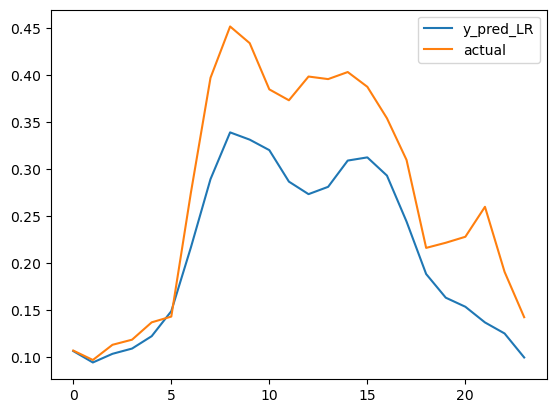

In [50]:
import random
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
randomList = [random.randint(0,2608130) for i in range(10)]
print(randomList)

for i in randomList:
    plt.plot(y_pred_lr[i], label='y_pred_LR')
    plt.plot(testY[i], label='actual')
    plt.legend()
    plt.show()

In [51]:
for i in randomList:
    lr_r2 = metrics.r2_score(testY, y_pred_lr)
    lr_rms = metrics.mean_squared_error(testY[i], y_pred_lr[i])
    lr_percentage_error = mean_absolute_percentage_error(testY[i], y_pred_lr[i])
    print(f"i = {i}\nModel's r2score: {lr_r2},\nRMS: {lr_rms},\nPercentage Error: {lr_percentage_error*100} %\n")

i = 84176
Model's r2score: 0.9480106634767015,
RMS: 0.004676058130605416,
Percentage Error: 10.19753175950553 %

i = 2414674
Model's r2score: 0.9480106634767015,
RMS: 0.001319746834603775,
Percentage Error: 5.21917849867953 %

i = 773683
Model's r2score: 0.9480106634767015,
RMS: 4.4408209102650795e-05,
Percentage Error: 6.144648378600323 %

i = 830611
Model's r2score: 0.9480106634767015,
RMS: 0.00010658963608702061,
Percentage Error: 1.0473698765996826 %

i = 1236733
Model's r2score: 0.9480106634767015,
RMS: 0.0003406455686347195,
Percentage Error: 2.934908409296178 %

i = 295200
Model's r2score: 0.9480106634767015,
RMS: 0.009218776302024981,
Percentage Error: 7403261169883389.0 %

i = 1505122
Model's r2score: 0.9480106634767015,
RMS: 0.018735660256634496,
Percentage Error: 30.817174558903286 %

i = 536178
Model's r2score: 0.9480106634767015,
RMS: 0.000893448497301746,
Percentage Error: 4.3211507945062815 %

i = 2335096
Model's r2score: 0.9480106634767015,
RMS: 0.004214997159985057,
Pe

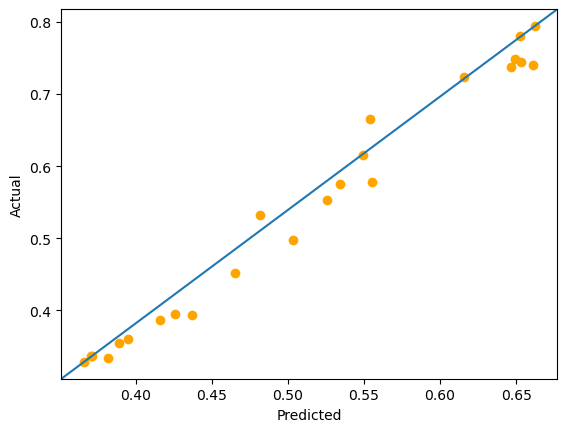

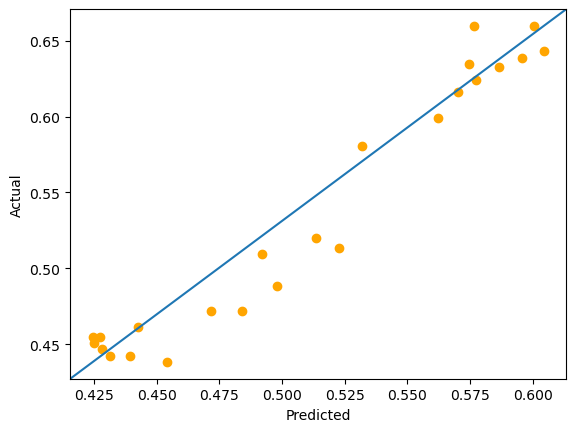

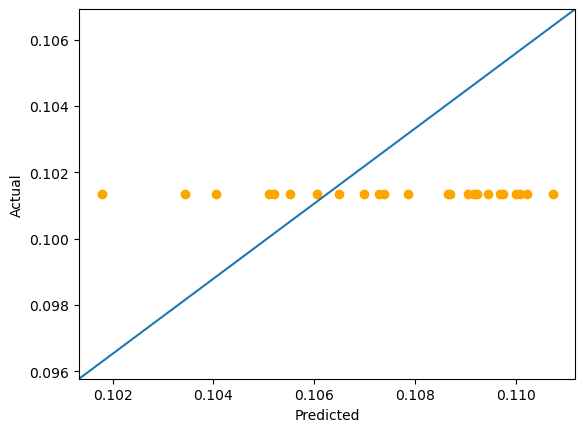

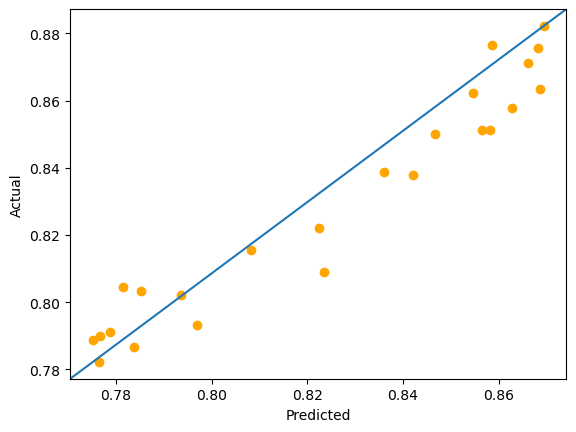

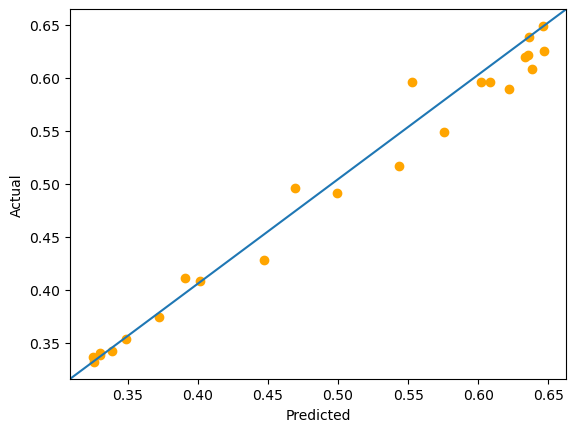

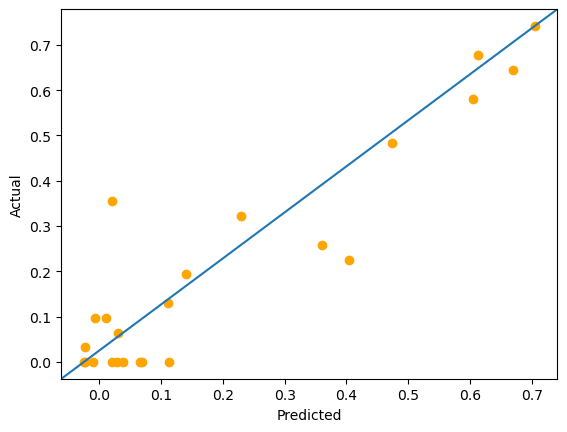

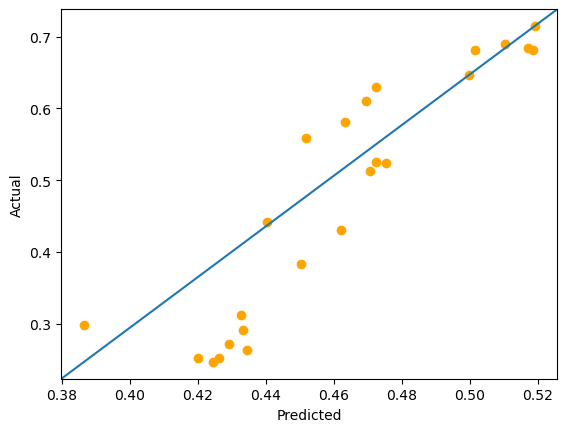

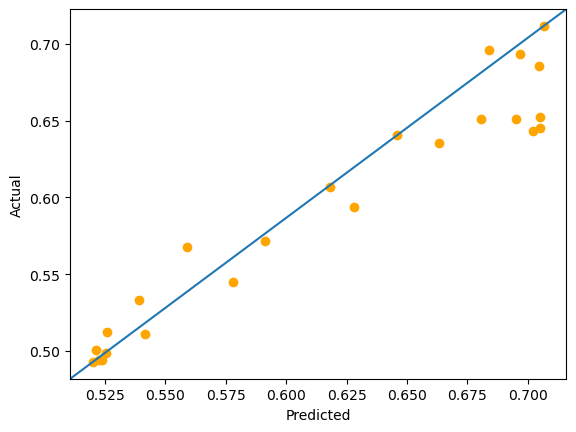

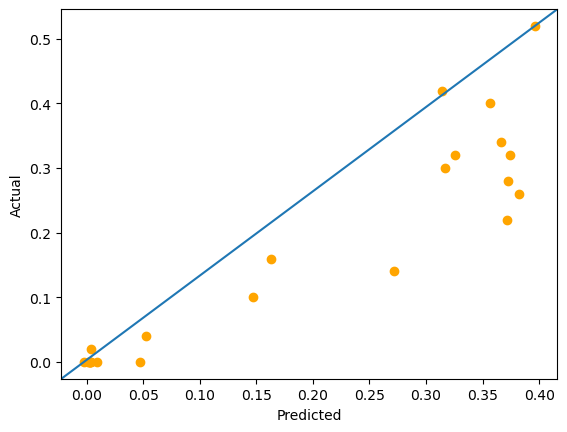

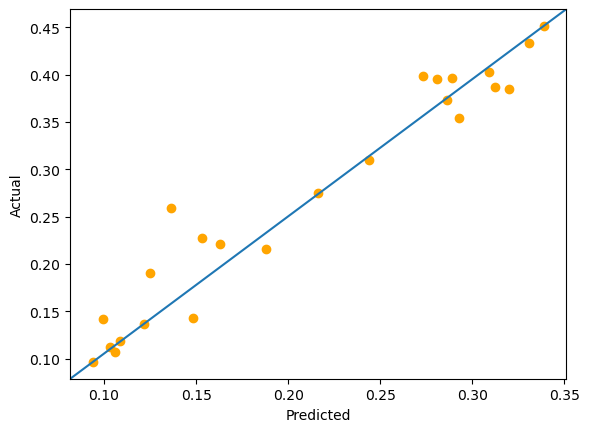

In [52]:
for i in randomList:
    plt.scatter(y_pred_lr[i], testY[i], label='Y_pred', color='orange')
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('Actual', fontsize=10)
    plt.show()

# Model 3: LSTM

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [60]:
# reshape input to be [samples, time steps, features]
trainX1 = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX1 = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(testX1.shape)

(2608130, 1, 192)


In [1]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(192, input_shape=(1,192), activation="relu"))
model.add(Dense(24,  activation="relu"))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX1, trainY, epochs=10, batch_size=128, verbose=2)

NameError: name 'Sequential' is not defined

In [64]:
ypred_lstm = model.predict(testX1[0])

   11/81505 [..............................] - ETA: 7:20    

2022-11-10 14:33:54.460284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


81505/81505 [==============================] - 416s 5ms/step


In [ ]:
for i in range(24):
    print("Hour{}:   MSE is {}" .format(i,mean_squared_error(testY[:,i], ypred_lstm[:,i])) )
    print("               R2 Score is {}" .format(r2_score(testY[:,i], ypred_lstm[:,i])) )
    print("               Percentage Error is {}" .format(mean_absolute_error(testY[:,i], ypred_lstm[:,i])) )

Hour0:       RMS is 0.0021674755483789233
        R2 Score is 0.9798385884083395
Percentage Error is 0
Hour1:       RMS is 0.003101125757068376
        R2 Score is 0.9711529330870922
Percentage Error is 1
Hour2:       RMS is 0.0038544333649333565
        R2 Score is 0.9641460039678306
Percentage Error is 2
Hour3:       RMS is 0.004380686437999644
        R2 Score is 0.9592523327208364
Percentage Error is 3
Hour4:       RMS is 0.004695423711887654
        R2 Score is 0.9563271851737539
Percentage Error is 4
Hour5:       RMS is 0.005034638893905739
        R2 Score is 0.9531757803079965
Percentage Error is 5
Hour6:       RMS is 0.005330153534645749
        R2 Score is 0.9504317915706594
Percentage Error is 6
Hour7:       RMS is 0.005541553222119979
        R2 Score is 0.9484692361671754
Percentage Error is 7
Hour8:       RMS is 0.005793532818368991
        R2 Score is 0.9461261900410924
Percentage Error is 8
Hour9:       RMS is 0.005912901102771065
        R2 Score is 0.9450166476657846


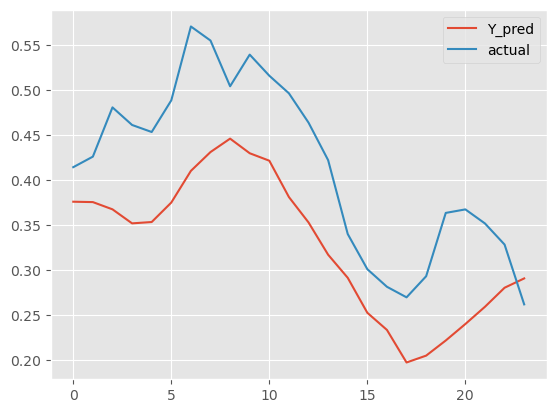

In [56]:
plt.plot(ypred_lstm[22], label='Y_pred')
plt.plot(testY[22], label='actual')
plt.legend()

Text(0, 0.5, 'Actual')

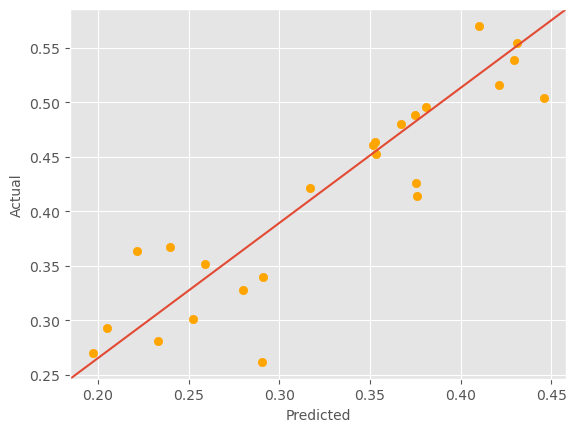

In [57]:
plt.scatter(ypred_lstm[22], testY[22], label='Y_pred', color='orange')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)

# Overall Flow

Suppose we have saved the most recent 8 days data in csv files. We can use the following code to generate a condensed csv file for recent data. The data in the condensed csv file will be used for prediction. Code below shows how to generate the condensed csv file from recent 8 days data.

In [42]:
def generate_recent_csv():
    df = load_data(11, days=9)
    df['available rate'] = df['lots_available'] / df['total_lots']
    grped = df.groupby(df.carpark_number)
    carparks = grped.carpark_number.unique()
    carparks = [carpark[0] for carpark in carparks]
    new_df = pd.DataFrame(columns=carparks)
    for id in carparks:
        slice = grped.get_group(id)
        slice = slice.resample('1h').mean()
        if slice.shape[0] != 24*8:
            print("Lossy data. Dropped")
            print(id)
            continue
        new_df[id] = slice['available rate'].values
    new_df.index = slice.index
    new_df.to_csv("./data/recent.csv")

generate_recent_csv()

Lossy data. Dropped
Y49H


In [14]:
from queue import PriorityQueue

def find_nearest(x, y, location_dict):
    shortest = PriorityQueue()
    for key, loc in location_dict.items():
        dist = (loc[0] - x)**2 + (loc[1] - y)**2
        shortest.put((-dist, key))
    size = shortest.qsize()
    res = [shortest.get()[1] for i in range(size)]
    res.reverse()
    return res

def create_location_dict(loc_info: pd.DataFrame):
    location_dict = {}
    for row in loc_info.iterrows():
        content = row[1]
        name = content[0]
        location = (content[2], content[3])
        location_dict[name] = location
    return location_dict



def model_predict(input):
    return input[-24:].values

In [15]:
loc_info = pd.read_csv("./data/hdb-carpark-information.csv")
recent = pd.read_csv("./data/recent.csv")
carpark_info = create_location_dict(loc_info)
top5 = find_nearest(30314.7936, 31490.4942, carpark_info)
for id in top5:
    if id not in recent.columns:
        print(f"one of the nearest carpark {id} is not in the recent data")
        continue
    col = recent[id][-24*8:]
    prediction = model_predict(col)
    print(f"carpark {id} prediction: {prediction}")

def init():
    model = load_model('model/mlp_sklearn_model.sav')
    print(" * Model loaded!")
    recent = pd.read_csv("./data/recent.csv")
    print(" * Recent data loaded!")
    return model, recent


def find_by_location(model, recent):
    print("Please enter your location")
    x = float(input("x: "))
    y = float(input("y: "))
    print("Finding nearest carpark...")
    top5 = find_nearest(x, y, carpark_info)
    for id in top5:
        if id not in recent.columns:
            print(f"one of the nearest carpark {id} is not in the recent data")
            continue
        col = recent[id][-24*8:]
        prediction = model_predict(col)
        print(f"carpark {id} prediction: {prediction}")

def find_by_carpark_number(model, recent):
    print("Please enter the carpark number")
    id = input("id: ")
    if id not in recent.columns:
        print(f"carpark {id} is not in the recent data")
        return
    col = recent[id][-24*8:]
    prediction = model_predict(col)
    print(f"carpark {id} prediction: {prediction}")


carpark ACB prediction: [0.64516129 0.64516129 0.64516129 0.55913978 0.5483871  0.52688172
 0.43010753 0.05376344 0.08602151 0.         0.01075269 0.07526882
 0.02150538 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.05376344 0.05376344        nan 0.03225806 0.03225806]
carpark CY prediction: [0.35483871 0.35483871 0.35483871 0.16129032 0.09677419 0.16129032
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.                nan 0.         0.        ]
carpark WCB prediction: [0.37062937 0.42657343 0.40559441 0.3986014  0.39160839 0.37762238
 0.37762238 0.29370629 0.3006993  0.13986014 0.00699301 0.00699301
 0.00699301 0.00699301 0.         0.         0.         0.
 0.         0.00699301 0.00699301        nan 0.00699301 0.00699301]
one of the nearest carpark SR2 is not in the recent data
one of the nearest carpark SR1 is not in the recent data


In [16]:
def app():
    model, recent = init()
    print("Welcome to the carpark availability prediction system")
    print("How would you like to query")
    print("1. By location")
    print("2. By carpark number")
    choice = input("Enter your choice: ")
    if choice == "1":
        find_by_location(model, recent)
    elif choice == "2":
        find_by_carpark_number(model, recent)